<a href="https://colab.research.google.com/github/haripy123/GANs/blob/main/WGAN_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision.transforms import v2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import os
from torchsummary import summary
from torch import optim

**Download `kaggle.json` from your kaggle account > API >Create API Token**

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:15<00:00, 80.1MB/s]
100% 1.33G/1.33G [00:15<00:00, 94.1MB/s]


In [4]:
!unzip -q /content/celeba-dataset.zip

In [5]:
class Celeb(Dataset):
  def __init__(self,dir,transform=None):
    super().__init__()
    self.dir=dir
    self.transform=transform
  def __len__(self):
    return len(os.listdir(self.dir))
  def __getitem__(self,idx):
    x=os.listdir(self.dir)[idx]
    img=read_image(os.path.join(self.dir,x))
    if self.transform:
      return self.transform(img)
    else:
      return img

In [6]:
dir='/content/img_align_celeba/img_align_celeba'
trans=v2.Compose([v2.ToDtype(torch.float32,scale=True),v2.Resize((64,64),antialias=True)])
data=Celeb(dir,trans)

In [11]:
batch=64
lr=5e-5
n_critic=5
w_clip=0.01
epochs=50
dim,n_channels,img_size=100,3,64
dataloader=DataLoader(data,shuffle=True,batch_size=batch,drop_last=True)

In [9]:
device='cuda' if torch.cuda.is_available() else 'cpu'

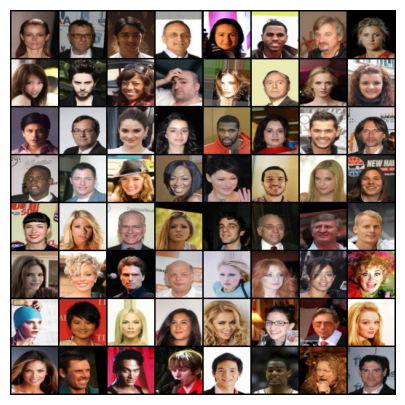

In [10]:
x=next(iter(dataloader))
grid=make_grid(x)
plt.figure(figsize=(10,5))
plt.imshow(grid.permute(1,2,0).clamp(0.,1.))
plt.axis('off')
plt.show()

In [12]:
class Generator(nn.Module):
    def __init__(self,dim,n_channels,img_size):
        super().__init__()
        self.dim=dim
        self.net=nn.Sequential(
            nn.ConvTranspose2d(dim,img_size*4,4,1,0,bias=False),
            nn.BatchNorm2d(img_size*4),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(img_size*4,img_size*2,4,2,1,bias=False),
            nn.BatchNorm2d(img_size*2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(img_size*2,img_size*2,4,2,1,bias=False),
            nn.BatchNorm2d(img_size*2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(img_size*2,img_size,4,2,1,bias=False),
            nn.BatchNorm2d(img_size),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(img_size,n_channels,4,2,1,bias=False),
            nn.Tanh(),
        )
    def forward(self,x):
        return self.net(x)

In [13]:
class Critic(nn.Module):
    def __init__(self,n_channels,img_size):
        super().__init__()
        self.net=nn.Sequential(
            nn.Conv2d(n_channels,img_size,4,2,1,bias=False),
            nn.BatchNorm2d(img_size),
            nn.LeakyReLU(),
            nn.Conv2d(img_size,img_size*2,4,2,1,bias=False),
            nn.BatchNorm2d(img_size*2),
            nn.LeakyReLU(),
            nn.Conv2d(img_size*2,img_size*2,4,2,1,bias=False),
            nn.BatchNorm2d(img_size*2),
            nn.LeakyReLU(),
            nn.Conv2d(img_size*2,img_size*4,4,2,1,bias=False),
            nn.BatchNorm2d(img_size*4),
            nn.LeakyReLU(),
            nn.Conv2d(img_size*4,1,4,1,0,bias=False),
        )
    def forward(self,x):
        return self.net(x)

In [14]:
def weight_init(mod):
    name=mod.__class__.__name__
    if 'Conv' in name:
        nn.init.normal_(mod.weight.data,0.,0.02)
    elif 'BatchNorm' in name:
        nn.init.normal_(mod.weight.data,1.,0.02)
        nn.init.constant_(mod.bias.data,0.)

In [23]:
gen=Generator(dim,n_channels,img_size).to(device)
critic=Critic(n_channels,img_size).to(device)
gen.apply(weight_init)
critic.apply(weight_init)
summary(gen,input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
       BatchNorm2d-2            [-1, 256, 4, 4]             512
         LeakyReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
         LeakyReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         262,144
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        LeakyReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [24]:
c_optim=optim.RMSprop(critic.parameters(),lr=lr)
g_optim=optim.RMSprop(gen.parameters(),lr=lr)

In [ ]:
print('Training......')
new_imgs=[]
c_l=[]
g_l=[]
for epoch in range(epochs):
  gen.train()
  critic.train()
  for imgs in dataloader:
    input=imgs.to(device)
    for c in range(n_critic):
      for p in critic.parameters():
        p.data.clamp_(-w_clip,w_clip)
      critic.zero_grad()
      noise=torch.randn(batch,dim,1,1,device=device)
      fake=gen(noise)
      loss_real=critic(input).reshape(-1)
      loss_fake=critic(fake.detach()).reshape(-1)
      loss_c=loss_fake.mean()-loss_real.mean()
      loss_c.backward()
      c_optim.step()
    gen.zero_grad()
    g_pred=critic(fake).reshape(-1)
    loss_gen=-(g_pred.mean())
    loss_gen.backward()
    g_optim.step()
    c_l.append(loss_c.item())
    g_l.append(loss_gen.item())
  print(f'epoch:{epoch},  critic_loss:{loss_c.item()} ,  gen_loss:{loss_gen.item()}')
  if (epoch+1)%10==0:
    with torch.no_grad():
      n_noise=torch.randn(64,100,1,1,device=device)
      n_imgs=gen(n_noise)
      new_imgs.append(make_grid(n_imgs.detach().cpu(),normalize=True))

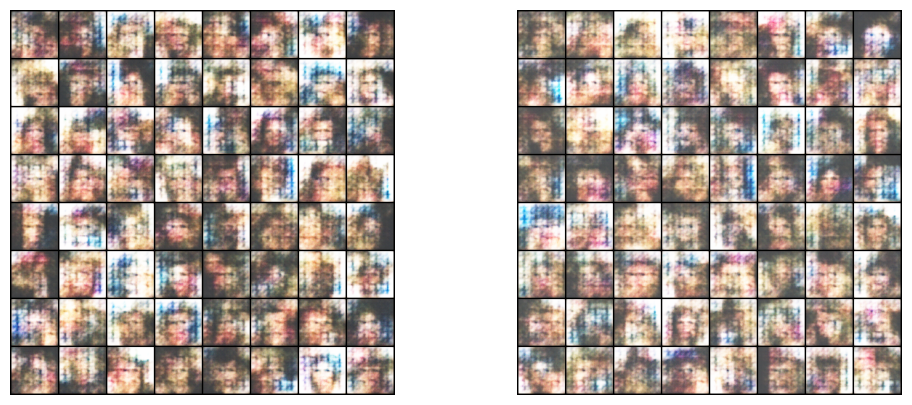

In [37]:
noi1=torch.randn(batch,dim,1,1).to(device)
noi2=torch.randn(batch,dim,1,1).to(device)
noi=[noi1,noi2]
plt.figure(figsize=(12,5))
for i in range(2):
  gen_imgs=gen(noi[i]).detach().cpu()
  grid=make_grid(gen_imgs,normalize=True)
  plt.subplot(1,2,i+1)
  plt.imshow(grid.permute(1,2,0))
  plt.axis('off')